<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/classify_text_with_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/bert/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

# Analise de sentimento com em português com BERT

fine-tuning BERT para análise de sentimento no dataset de ecommerce brasileiro Olist.

## About BERT

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers.

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


## Setup


In [ ]:
%pip install transformers

In [ ]:
import transformers
#
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
#
from tqdm import tqdm
from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn.functional as F
import json
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW  # agora direto do PyTorch
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import defaultdict
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
print(torch.__version__)
print(torch.cuda.is_available())  # Deve ser False se for CPU-only

2.6.0+cu124
True


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Caminho para o arquivo CSV
csv_path = "olist_ecommerce_data.csv"

# Carregar o CSV em um DataFrame
df = pd.read_csv(csv_path)

# Exibir as primeiras linhas
df.head()

,Texto,review_score,Label
0,Recebi bem antes do prazo estipulado.,5,1
1,Parabéns lojas lannister adorei comprar pela I...,5,1
2,aparelho eficiente. no site a marca do aparelh...,4,1
3,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",4,1
4,"Vendedor confiável, produto ok e entrega antes...",5,1


In [ ]:
# Carregando o tokenizador do modelo BERTIMBAU da hugging face.

PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Testando a forma como o modelo tokeniza uma frase.

sample_txt = 'Quem conta um conto aumenta um ponto'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Quem conta um conto aumenta um ponto
   Tokens: ['Quem', 'conta', 'um', 'conto', 'aumenta', 'um', 'ponto']
Token IDs: [15807, 1284, 222, 12059, 8101, 222, 2009]


In [ ]:
''' A função encode_plus() do tokenizador do bertimbau prepara os dados para serem usados no modelo (máscara de atenção, padding, truncamento ...)
    Trata-se de um empacotador de texto para o bert que está retornando tensores pytorch dentro do dicionário encoding '''

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=16,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Keyword arguments {'pad_to_max_length': True} not recognized.


KeysView({'input_ids': tensor([[  101, 15807,  1284,   222, 12059,  8101,   222,  2009,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])})

In [ ]:
# Tensor pytorch input_ids gerado
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

9


tensor([  101, 15807,  1284,   222, 12059,  8101,   222,  2009,   102])

In [ ]:
# Tensor pytorch input_ids decodificado
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['[CLS]', 'Quem', 'conta', 'um', 'conto', 'aumenta', 'um', 'ponto', '[SEP]']


In [ ]:
''' Coleta a quantidade de tokens por texto para ajudar a definir o MAX_LEN
    512 é o tamanho máximo permitido pelo BERT base. Dessa forma vamos achar um tamanho ótimo
    considerando o dataset '''

token_lens = []

for txt in df.Texto:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/tmp/ipython-input-661343942.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


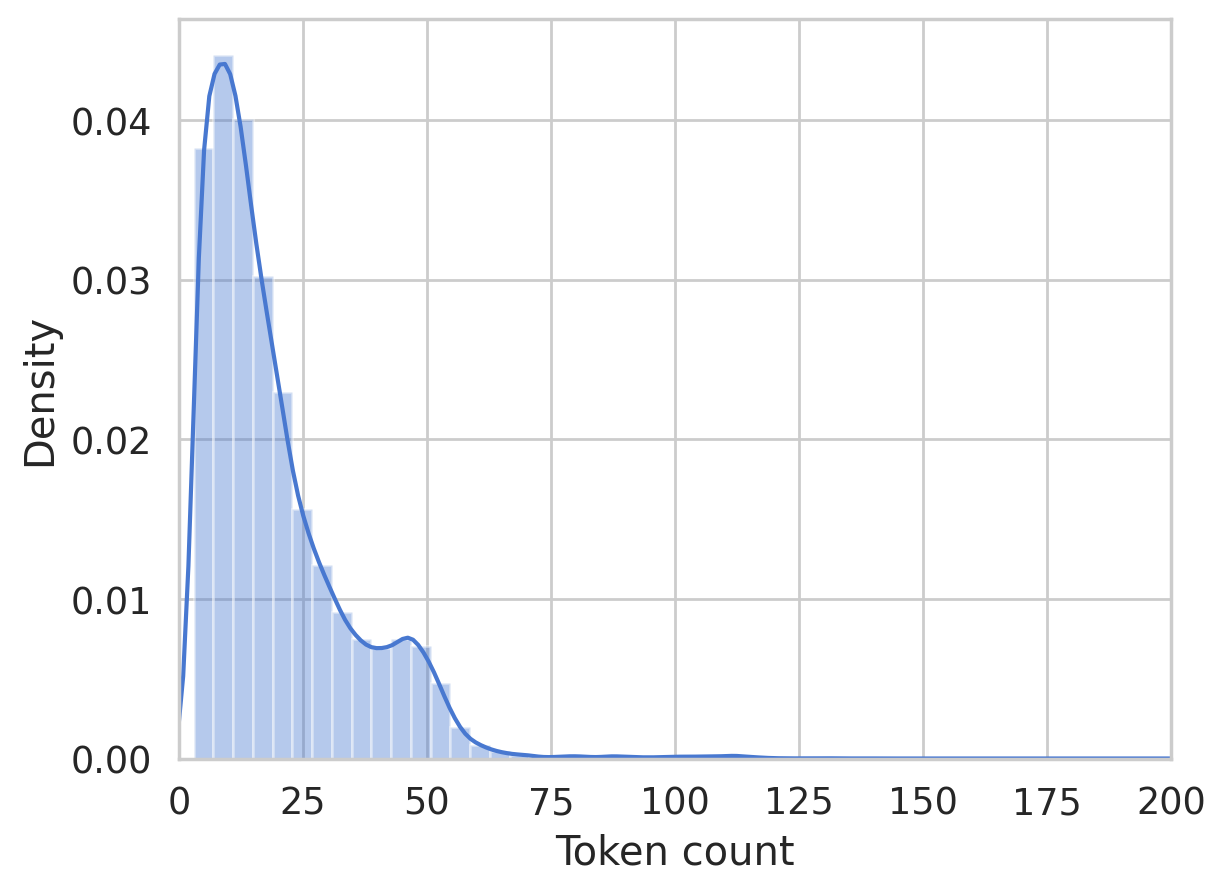

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 200]);
plt.xlabel('Token count');

Let's try the preprocessing model on some text and see the output:

In [ ]:
MAX_LEN = 128

In [ ]:
''' Definição de seed aleatória para os geradores de números aleatórios do numpy e pytorch '''

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
# Essa parte define um dataset personalizado do pytorch. Ele usa o tokenizer para codificar cada texto e
# retorna os tensores input_ids, attention_mask, targets e mais os reviews para debugging se necessário.

class ReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
# Criando os datasets de treino, validação e teste
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((36855, 3), (2047, 3), (2048, 3))

In [ ]:
# Essa função usa a classe ReviewDataset e retorna um dataloader pytorch

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ReviewDataset(
    reviews=df.Texto.to_numpy(),
    targets=df.Label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
len(train_data_loader)

2304

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16])


In [ ]:
''' Cria um modelo com:

BERTimbau como base,

Camada Dropout,

Camada Linear para classificar em duas classes (positivo e negativo). '''

class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    #The last_hidden_state is a sequence of hidden states of the last layer of the model
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)


In [ ]:
class_names = ['Negativo', 'Positivo']

model = SentimentClassifier(len(class_names))
model = model.to(device)


In [ ]:
''' AdamW: variante do Adam recomendada para Transformers.
    scheduler: ajusta o learning rate ao longo do tempo. '''

EPOCHS = 4

optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
# Treina o modelo por uma época e avalia no conjunto de validação

def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# %%time

# history = defaultdict(list)
# best_accuracy = 0

# for epoch in range(EPOCHS):

#   print(f'Epoch {epoch + 1}/{EPOCHS}')
#   print('-' * 10)

#   train_acc, train_loss = train_epoch(
#     model,
#     train_data_loader,
#     loss_fn,
#     optimizer,
#     device,
#     scheduler,
#     len(df_train)
#   )

#   print(f'Train loss {train_loss} accuracy {train_acc}')

#   val_acc, val_loss = eval_model(
#     model,
#     val_data_loader,
#     loss_fn,
#     device,
#     len(df_val)
#   )

#   print(f'Val   loss {val_loss} accuracy {val_acc}')
#   print()

#   history['train_acc'].append(train_acc)
#   history['train_loss'].append(train_loss)
#   history['val_acc'].append(val_acc)
#   history['val_loss'].append(val_loss)

#   if val_acc > best_accuracy:
#     torch.save(model.state_dict(), 'best_model_state.bin')
#     best_accuracy = val_acc

In [ ]:
# %%time

# history = defaultdict(list)
# best_accuracy = 0
# # Definir seed e KFold
# seed = 42
# n_splits = 5
# kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

# results = []

# for fold, (train_idx, val_idx) in enumerate(kf.split(df), 1):
#     print(f"\n===== FOLD {fold} =====")

#     # Dividir o DataFrame em treino e validação
#     df_train = df.iloc[train_idx]
#     df_val = df.iloc[val_idx]

#     # Criar DataLoaders
#     train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
#     val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

#     # Instanciar modelo
#     model = SentimentClassifier(len(class_names))
#     model = model.to(device)

#     optimizer = AdamW(model.parameters(), lr=2e-5)
#     total_steps = len(train_data_loader) * EPOCHS
#     scheduler = get_linear_schedule_with_warmup(
#         optimizer,
#         num_warmup_steps=0,
#         num_training_steps=total_steps
#     )
#     loss_fn = nn.CrossEntropyLoss().to(device)

#     # Treinar
#     for epoch in range(EPOCHS):
#         train_acc, train_loss = train_epoch(
#             model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train)
#         )
#         val_acc, val_loss = eval_model(
#             model, val_data_loader, loss_fn, device, len(df_val)
#         )
#         print(f"Epoch {epoch+1}/{EPOCHS} - Train acc: {train_acc:.4f} Val acc: {val_acc:.4f} Train loss {train_loss:.4f} Val   loss {val_loss:.4f}")
#         if val_acc > best_accuracy:
#           torch.save(model.state_dict(), '/content/drive/MyDrive/best_bert_model_after_kfold.bin')
#           best_accuracy = val_acc

#     # Avaliação final
#     val_acc, _ = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
#     results.append(val_acc)

# print(f"Resultados finais:", results)
# results = [acc.item() if torch.is_tensor(acc) else acc for acc in results]
# print(f"Média de Accuracy: {np.mean(results):.4f}")



In [ ]:
# results = [acc.item() if torch.is_tensor(acc) else acc for acc in results]
# print(f"Média de Accuracy: {np.mean(results):.4f}")

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['Negativo', 'Positivo']

model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('/content/drive/MyDrive/best_bert_model_after_kfold.bin'))
model = model.to(device)
model.eval()

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [ ]:
''' review_texts: textos de entrada

predictions: classes preditas

prediction_probs: probabilidades

real_values: rótulos reais '''

def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

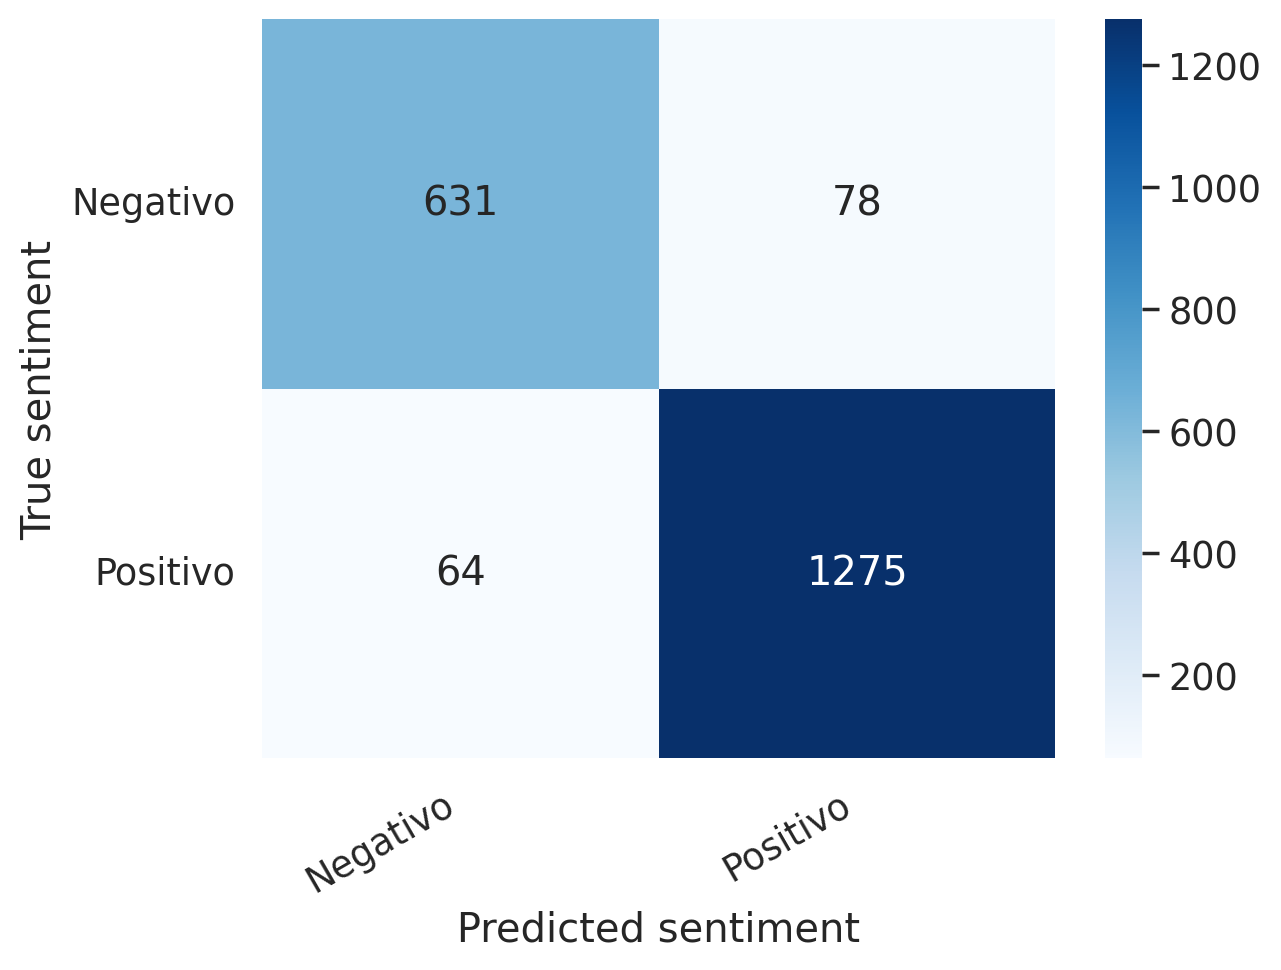

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
y_test = np.array(y_test)
y_pred = np.array(y_pred)

# Macro F1 Score
macro_f1_score = f1_score(y_test, y_pred, average='macro')
print("Macro F1 Score:", macro_f1_score)

# Macro Precision
macro_precision = precision_score(y_test, y_pred, average='macro')
print("Macro Precision:", macro_precision)

# Macro Recall
macro_recall = recall_score(y_test, y_pred, average='macro')
print("Macro Recall:", macro_recall)

Macro F1 Score: 0.9230557566367372
Macro Precision: 0.9251320008294917
Macro Recall: 0.9210945161484003


In [ ]:
tests = ["Eu gostaria de fazer uma avaliação sincera aqui e ver se o modelo vai identificar. Mas esse é só um teste, \
          então nao consigo dizer se gosto ou nao gosto. Pode ser bom ou pode ser ruim :):(:",

        "Esse aplicativo é muito louco, bem complicado de mexer",

         "Na moral, tá pra nascer app melhor que o Zé delivery!. Bebida sempre gelada e em minutos."
         ]

In [ ]:
''' Testando com frases manualmente '''
for test in tests:
  encoded_review = tokenizer.encode_plus(
    test,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt',
  )

  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  probs = F.softmax(output, dim=1)

  print(f'Review text: {test}')
  print(pd.DataFrame(probs.tolist()[0], class_names)[0])
  print("========================\n")

Review text: Eu gostaria de fazer uma avaliação sincera aqui e ver se o modelo vai identificar. Mas esse é só um teste,           então nao consigo dizer se gosto ou nao gosto. Pode ser bom ou pode ser ruim :):(:
Negativo    0.76643
Positivo    0.23357
Name: 0, dtype: float64

Review text: Esse aplicativo é muito louco, bem complicado de mexer
Negativo    0.969294
Positivo    0.030706
Name: 0, dtype: float64

Review text: Na moral, tá pra nascer app melhor que o Zé delivery!. Bebida sempre gelada e em minutos.
Negativo    0.040513
Positivo    0.959487
Name: 0, dtype: float64



In [ ]:
# # Caminho para o arquivo CSV
# csv_path_respostas_unificadas = "feedbacks_alunos.csv"

# # Carregar o CSV em um DataFrame
# df_respostas_unificadas = pd.read_csv(csv_path_respostas_unificadas)

# # Exibir as primeiras linhas
# print(len(df_respostas_unificadas))

In [ ]:
# df_respostas_unificadas.columns

# df_respostas_unificadas = df_respostas_unificadas.dropna(subset=['feedback'])  # remove NaN
# df_respostas_unificadas = df_respostas_unificadas[df_respostas_unificadas['feedback'].str.strip() != '']  # remove strings vazias ou só espaços

# # df_respostas_unificadas.to_csv("feedbacks_alunos_preprocessado.csv", index=False)


In [ ]:
# sentimentos = []  # lista para guardar os sentimentos

# texto_feedbacks = df_respostas_unificadas['feedback'].to_list()

# for feedback in texto_feedbacks:
#     # Tokenização do feedback
#     encoded_review = tokenizer.encode_plus(
#         feedback,
#         max_length=MAX_LEN,
#         add_special_tokens=True,
#         return_token_type_ids=False,
#         padding='max_length',
#         truncation=True,
#         return_attention_mask=True,
#         return_tensors='pt',
#     )

#     input_ids = encoded_review['input_ids'].to(device)
#     attention_mask = encoded_review['attention_mask'].to(device)

#     # Geração da predição
#     output = model(input_ids, attention_mask)
#     _, prediction = torch.max(output, dim=1)

#     # Converter para rótulo de sentimento
#     label = 'positivo' if prediction.item() == 1 else 'negativo'
#     sentimentos.append(label)

# # Adiciona a nova coluna ao DataFrame
# df_respostas_unificadas['sentimento'] = sentimentos

# df_respostas_unificadas.head()

In [ ]:
# if "tab" in df_respostas_unificadas.columns:
#     df_respostas_unificadas = df_respostas_unificadas.rename(columns={"tab": "semestre"})

# # Salvar em CSV (opcional)
# df_respostas_unificadas.to_csv("feedbacks_alunos_com_sentimento.csv", index=False)

In [ ]:
df_respostas_com_sentimento = pd.read_csv("feedbacks_alunos_com_sentimento.csv")
df_respostas_com_sentimento.head()

,feedback,semestre,coluna_origem,acho_util,curso,sentimento
0,"Para mim, o ideal agora seria o modelo remoto ...",2021.2 - pandemia,Descreva o que você está achando desde modelo ...,SIM,Licenciatura em Computação (noturno),negativo
1,​Apesar de nada substituir o ensino presencial...,2021.2 - pandemia,Descreva o que você está achando desde modelo ...,SIM,Ciência da Computação,positivo
2,"Olha complicado essa questão, mas acho bom, pa...",2021.2 - pandemia,Descreva o que você está achando desde modelo ...,SIM,Licenciatura em Computação (noturno),positivo
3,"Apesar dos pontos negativos do ensino remoto, ...",2021.2 - pandemia,Descreva o que você está achando desde modelo ...,SIM,Ciência da Computação,positivo
4,O modelo de ensino remoto oferece diversas van...,2021.2 - pandemia,Descreva o que você está achando desde modelo ...,SIM,Ciência da Computação,negativo


In [ ]:
# Dicionario para converter tab da planilha em semestre
dicionario_semestres = {
    'analise_ensino_remoto': '2021.2 - pandemia',
    'avaliacao_da_disciplina': '2021.2 - pandemia',
    'analise_primeiro_semestre': '2021.2 - pandemia',
    'Licenciatura': '2021.2 - pandemia',
    'Avaliação da Disciplina 20221': '2022.1 - presencial'
    }

# Aplicar substituição no DataFrame
# df_respostas_com_sentimento["tab"] = df_respostas_com_sentimento["tab"].replace(dicionario_semestres)
# df_respostas_com_sentimento.rename(columns={"tab": "semestre"}, inplace=True)

In [ ]:
# Análise 1: Sentimentos por curso (foco nos dois principais)
dados_analise1 = df_respostas_com_sentimento.groupby(["curso", "sentimento"]).size().reset_index(name="quantidade")

# # Análise 2: Sentimentos por semestre
df_semestre = df_respostas_com_sentimento.dropna(subset=["semestre"])
dados_analise2 = df_semestre.groupby(["semestre", "sentimento"]).size().reset_index(name="quantidade")

# # Análise 3: Sentimento vs percepção de utilidade
df_util = df_respostas_com_sentimento[df_respostas_com_sentimento["acho_util"].isin(["SIM", "UM POUCO"])]
dados_analise3 = df_util.groupby(["acho_util", "sentimento"]).size().reset_index(name="quantidade")

# # Análise 4: Sentimento por curso e semestre
dados_analise4 = df_respostas_com_sentimento.groupby(["curso", "semestre", "sentimento"]).size().reset_index(name="quantidade")

# Análise 5: Seleção aleatória de amostras para comparação manual x automática
# (mudar n para ter mais exemplos)
amostras_analise5 = df_respostas_com_sentimento[["feedback", "sentimento"]].sample(n=10, random_state=42)

In [ ]:
dados_analise4.head(10)

,curso,semestre,sentimento,quantidade
0,Ciência da Computação,2021.2 - pandemia,negativo,97
1,Ciência da Computação,2021.2 - pandemia,positivo,249
2,Ciência da Computação,2022.1 - presencial,negativo,18
3,Ciência da Computação,2022.1 - presencial,positivo,74
4,Licenciatura em Computação (noturno),2021.2 - pandemia,negativo,28
5,Licenciatura em Computação (noturno),2021.2 - pandemia,positivo,57
6,Licenciatura em Computação (noturno),2022.1 - presencial,negativo,1
7,Licenciatura em Computação (noturno),2022.1 - presencial,positivo,13


In [ ]:
# Calcular total por curso para obter porcentagem
dados_analise1["total"] = dados_analise1.groupby("curso")["quantidade"].transform("sum")
dados_analise1["porcentagem"] = (dados_analise1["quantidade"] / dados_analise1["total"]) * 100

dados_analise2["total"] = dados_analise2.groupby("semestre")["quantidade"].transform("sum")
dados_analise2["porcentagem"] = (dados_analise2["quantidade"] / dados_analise2["total"]) * 100

dados_analise3["total"] = dados_analise3.groupby("acho_util")["quantidade"].transform("sum")
dados_analise3["porcentagem"] = (dados_analise3["quantidade"] / dados_analise3["total"]) * 100

dados_analise4["total"] = dados_analise4.groupby(["curso","semestre"])["quantidade"].transform("sum")
dados_analise4["porcentagem"] = (dados_analise4["quantidade"] / dados_analise4["total"]) * 100



# print(dados_analise1["porcentagem"])
dados_analise4.head(10)
# print(dados_analise1["total"].iloc[0])

,curso,semestre,sentimento,quantidade,total,porcentagem
0,Ciência da Computação,2021.2 - pandemia,negativo,97,346,28.034682
1,Ciência da Computação,2021.2 - pandemia,positivo,249,346,71.965318
2,Ciência da Computação,2022.1 - presencial,negativo,18,92,19.565217
3,Ciência da Computação,2022.1 - presencial,positivo,74,92,80.434783
4,Licenciatura em Computação (noturno),2021.2 - pandemia,negativo,28,85,32.941176
5,Licenciatura em Computação (noturno),2021.2 - pandemia,positivo,57,85,67.058824
6,Licenciatura em Computação (noturno),2022.1 - presencial,negativo,1,14,7.142857
7,Licenciatura em Computação (noturno),2022.1 - presencial,positivo,13,14,92.857143


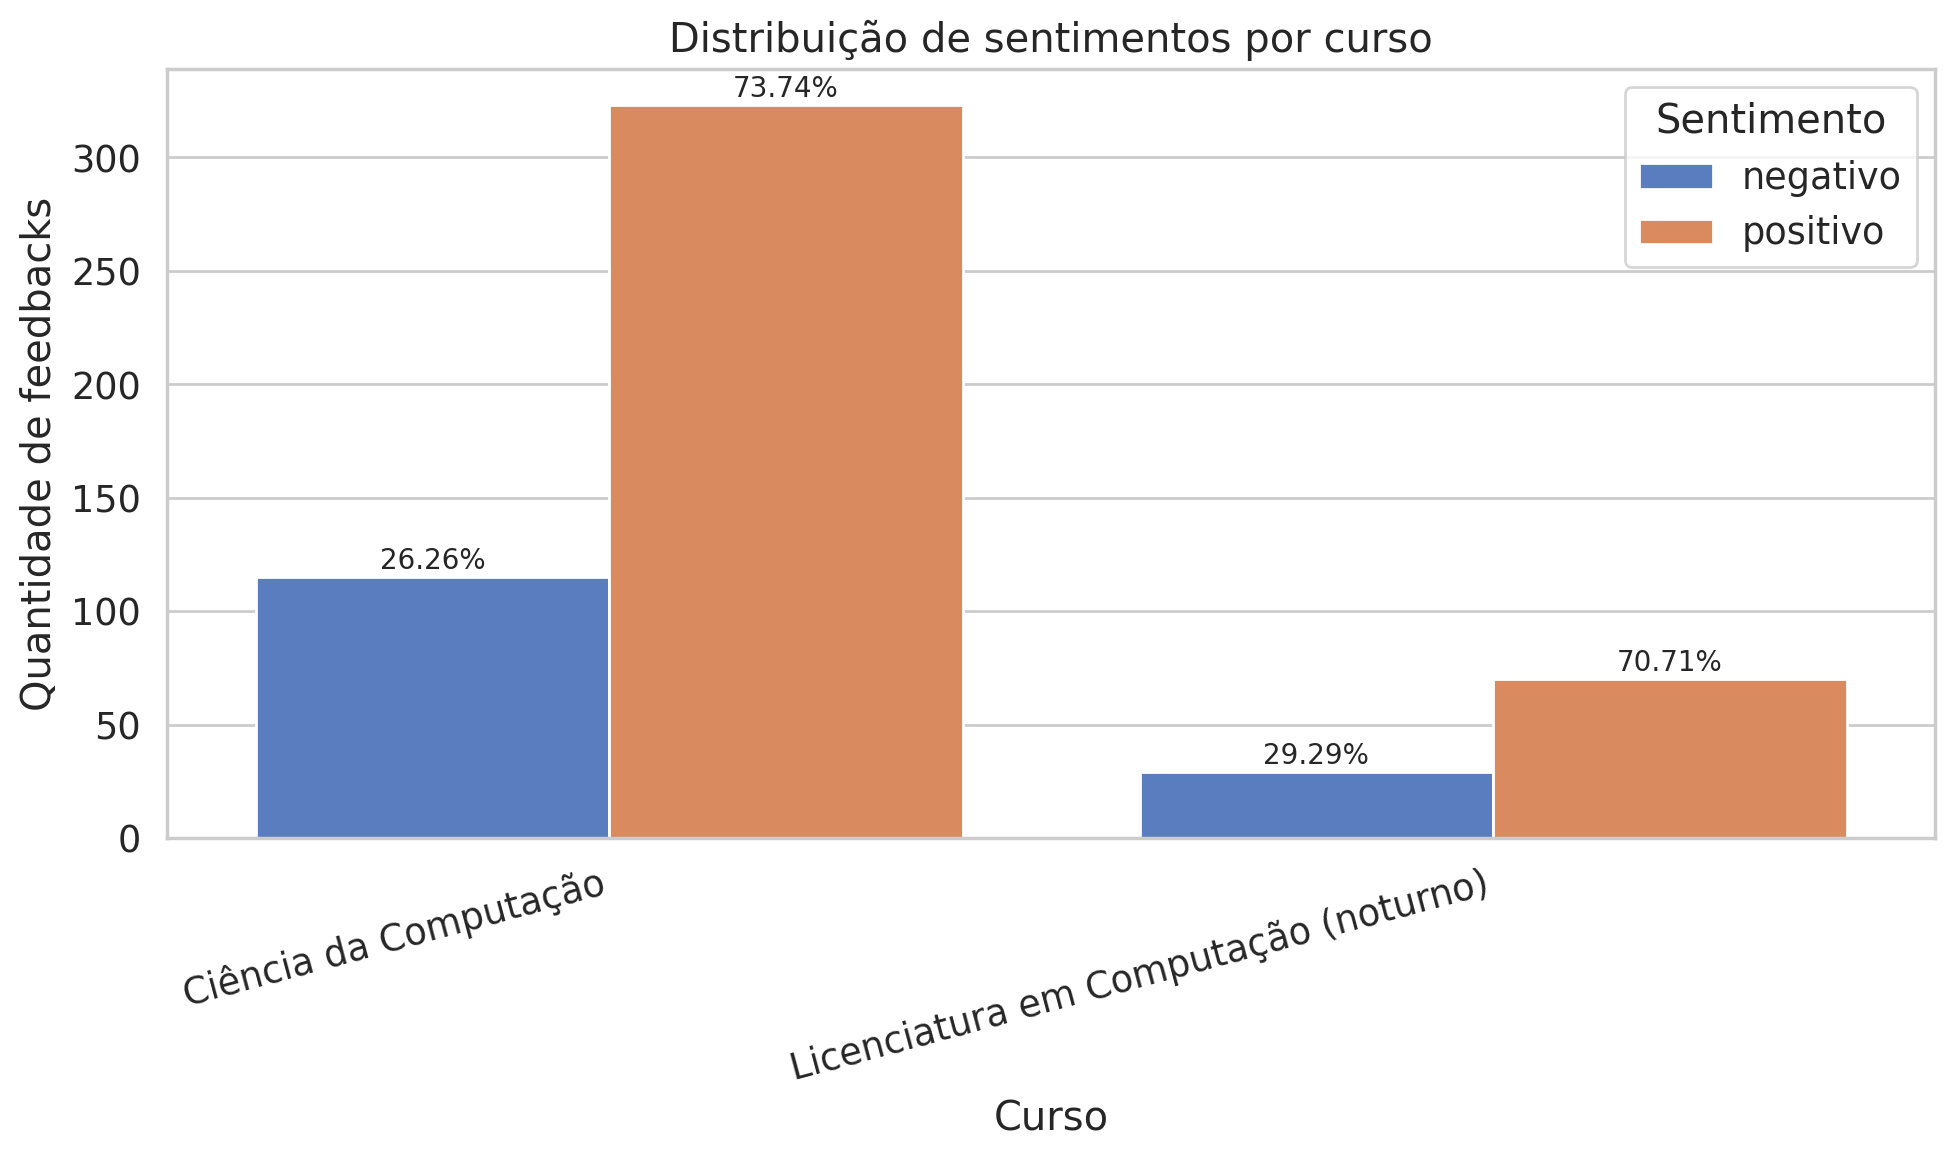

In [ ]:
# Criando gráfico de sentimento por curso
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=dados_analise1, x="curso", y="quantidade", hue="sentimento")
dados_analise1.sort_values(by="sentimento", inplace=True)
count = 0
for patch in ax.patches:
    if(count == len(dados_analise1)):
      break
    else:
      altura = patch.get_height()
      porcentagem = dados_analise1["porcentagem"].iloc[count]

      ax.text(patch.get_x() + patch.get_width() / 2, altura + 1,  # Posição do texto
          f'{porcentagem:.2f}%',  # Formatação do percentual
          ha='center', va='bottom', fontsize=10)
      count += 1

# Título e rótulos
plt.title("Distribuição de sentimentos por curso")
plt.xlabel("Curso")
plt.ylabel("Quantidade de feedbacks")
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.legend(title="Sentimento")
plt.show()

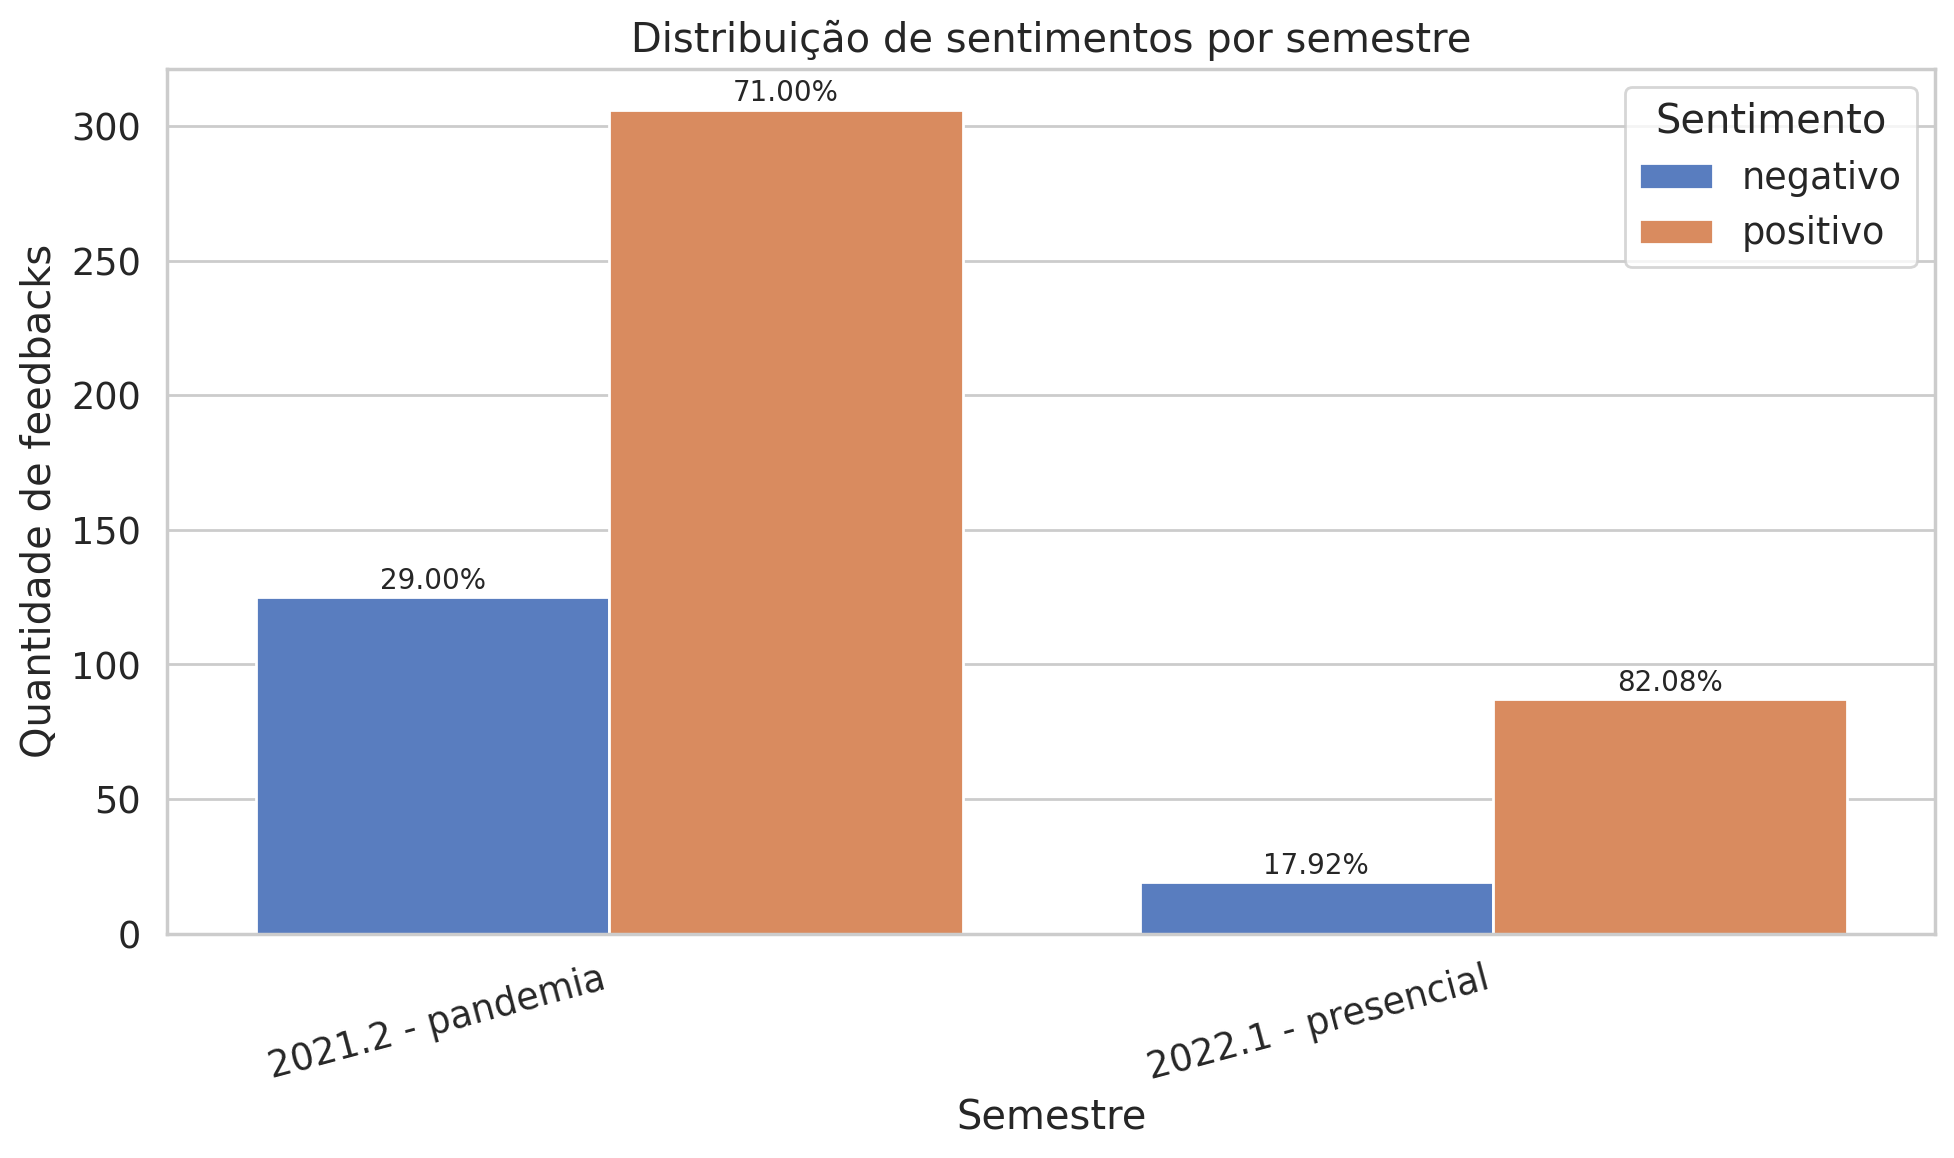

In [ ]:
# Criando gráfico de sentimento por semestre
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=dados_analise2, x="semestre", y="quantidade", hue="sentimento")
dados_analise2.sort_values(by="sentimento", inplace=True)
count = 0
for patch in ax.patches:
    if(count == len(dados_analise2)):
      break
    else:
      altura = patch.get_height()
      porcentagem = dados_analise2["porcentagem"].iloc[count]

      ax.text(patch.get_x() + patch.get_width() / 2, altura + 1,  # Posição do texto
          f'{porcentagem:.2f}%',  # Formatação do percentual
          ha='center', va='bottom', fontsize=10)
      count += 1

# Título e rótulos
plt.title("Distribuição de sentimentos por semestre")
plt.xlabel("Semestre")
plt.ylabel("Quantidade de feedbacks")
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.legend(title="Sentimento")
plt.show()

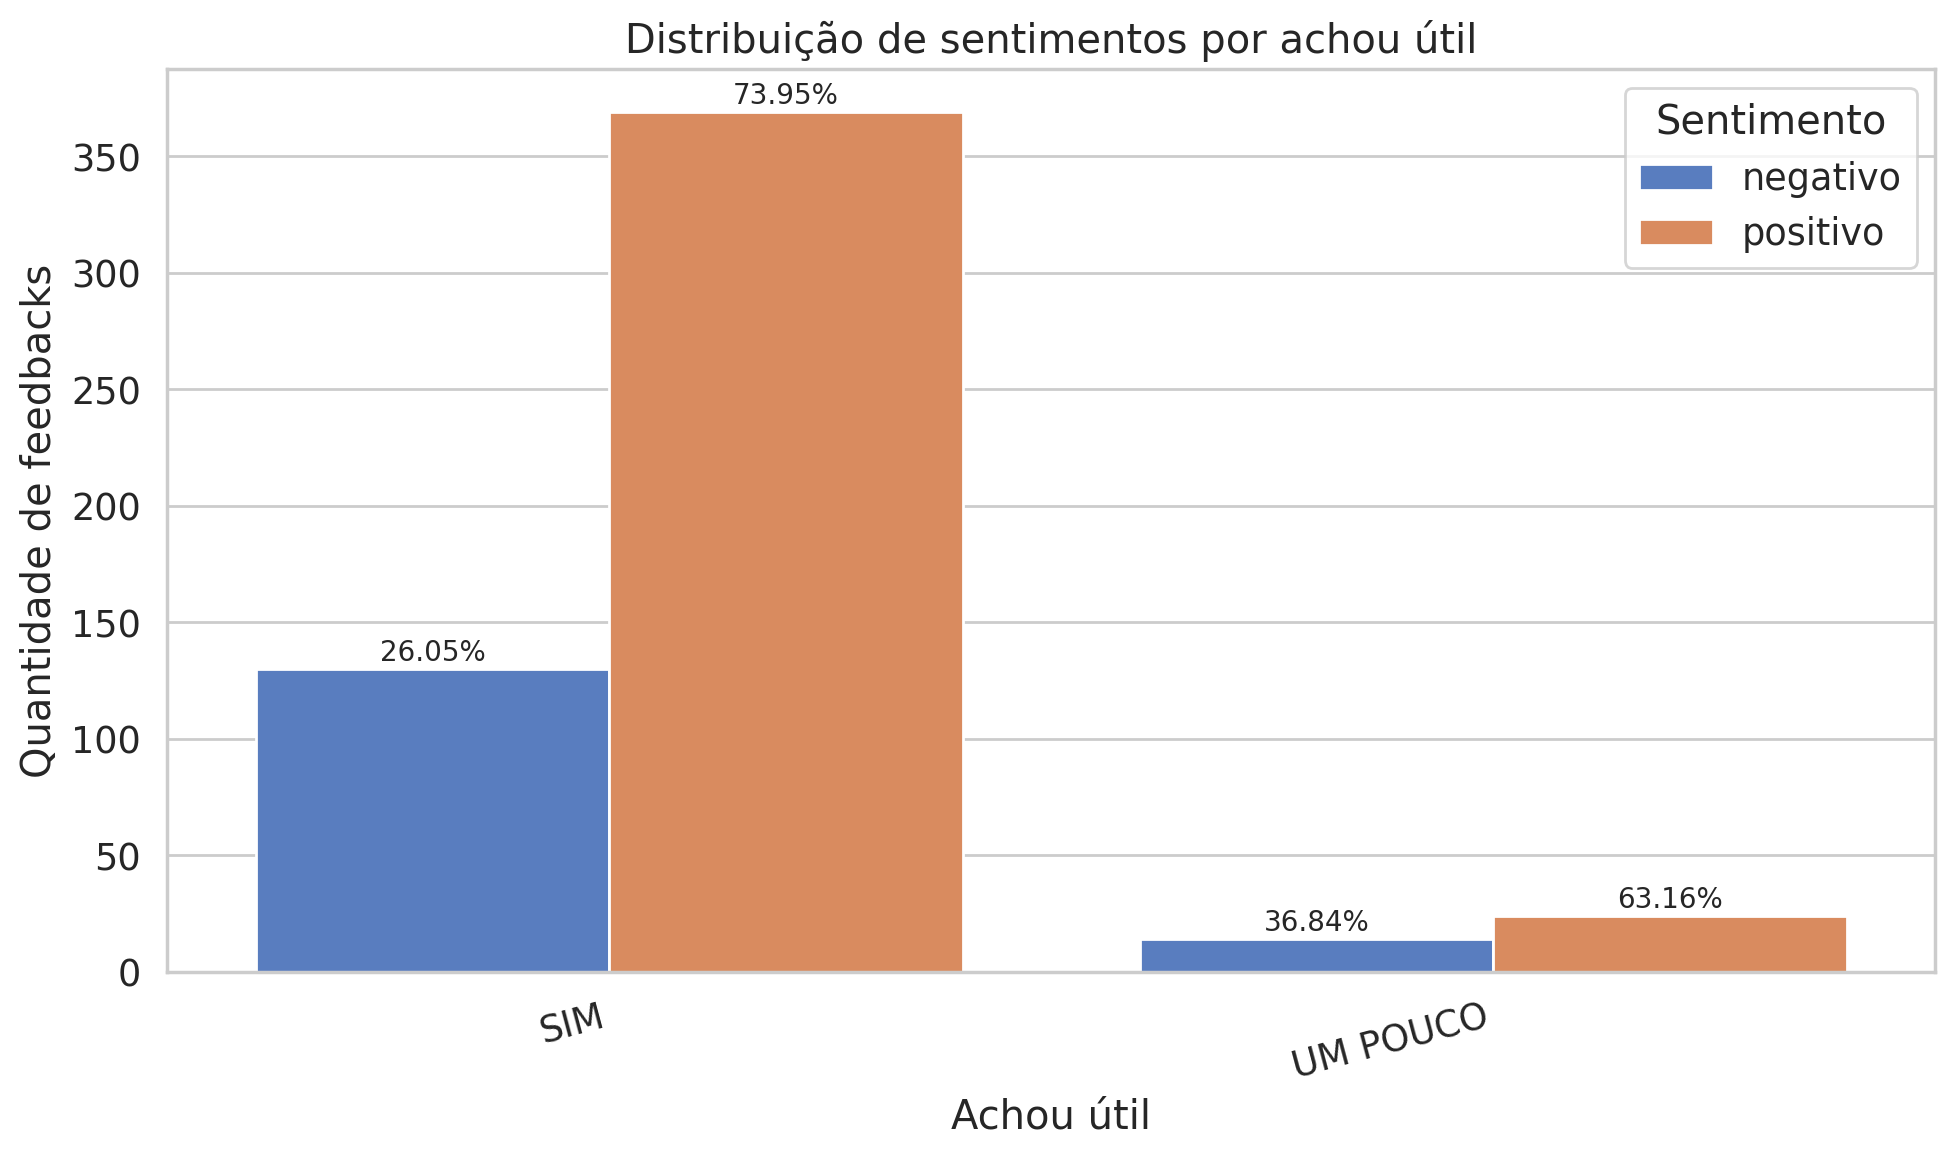

In [ ]:
# Criando gráfico de sentimento por achou útil
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=dados_analise3, x="acho_util", y="quantidade", hue="sentimento")
dados_analise3.sort_values(by="sentimento", inplace=True)
count = 0
for patch in ax.patches:
    if(count == len(dados_analise3)):
      break
    else:
      altura = patch.get_height()
      porcentagem = dados_analise3["porcentagem"].iloc[count]

      ax.text(patch.get_x() + patch.get_width() / 2, altura + 1,  # Posição do texto
          f'{porcentagem:.2f}%',  # Formatação do percentual
          ha='center', va='bottom', fontsize=10)
      count += 1

# Título e rótulos
plt.title("Distribuição de sentimentos por achou útil")
plt.xlabel("Achou útil")
plt.ylabel("Quantidade de feedbacks")
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.legend(title="Sentimento")
plt.show()

/tmp/ipython-input-2449679466.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right')
/tmp/ipython-input-2449679466.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right')


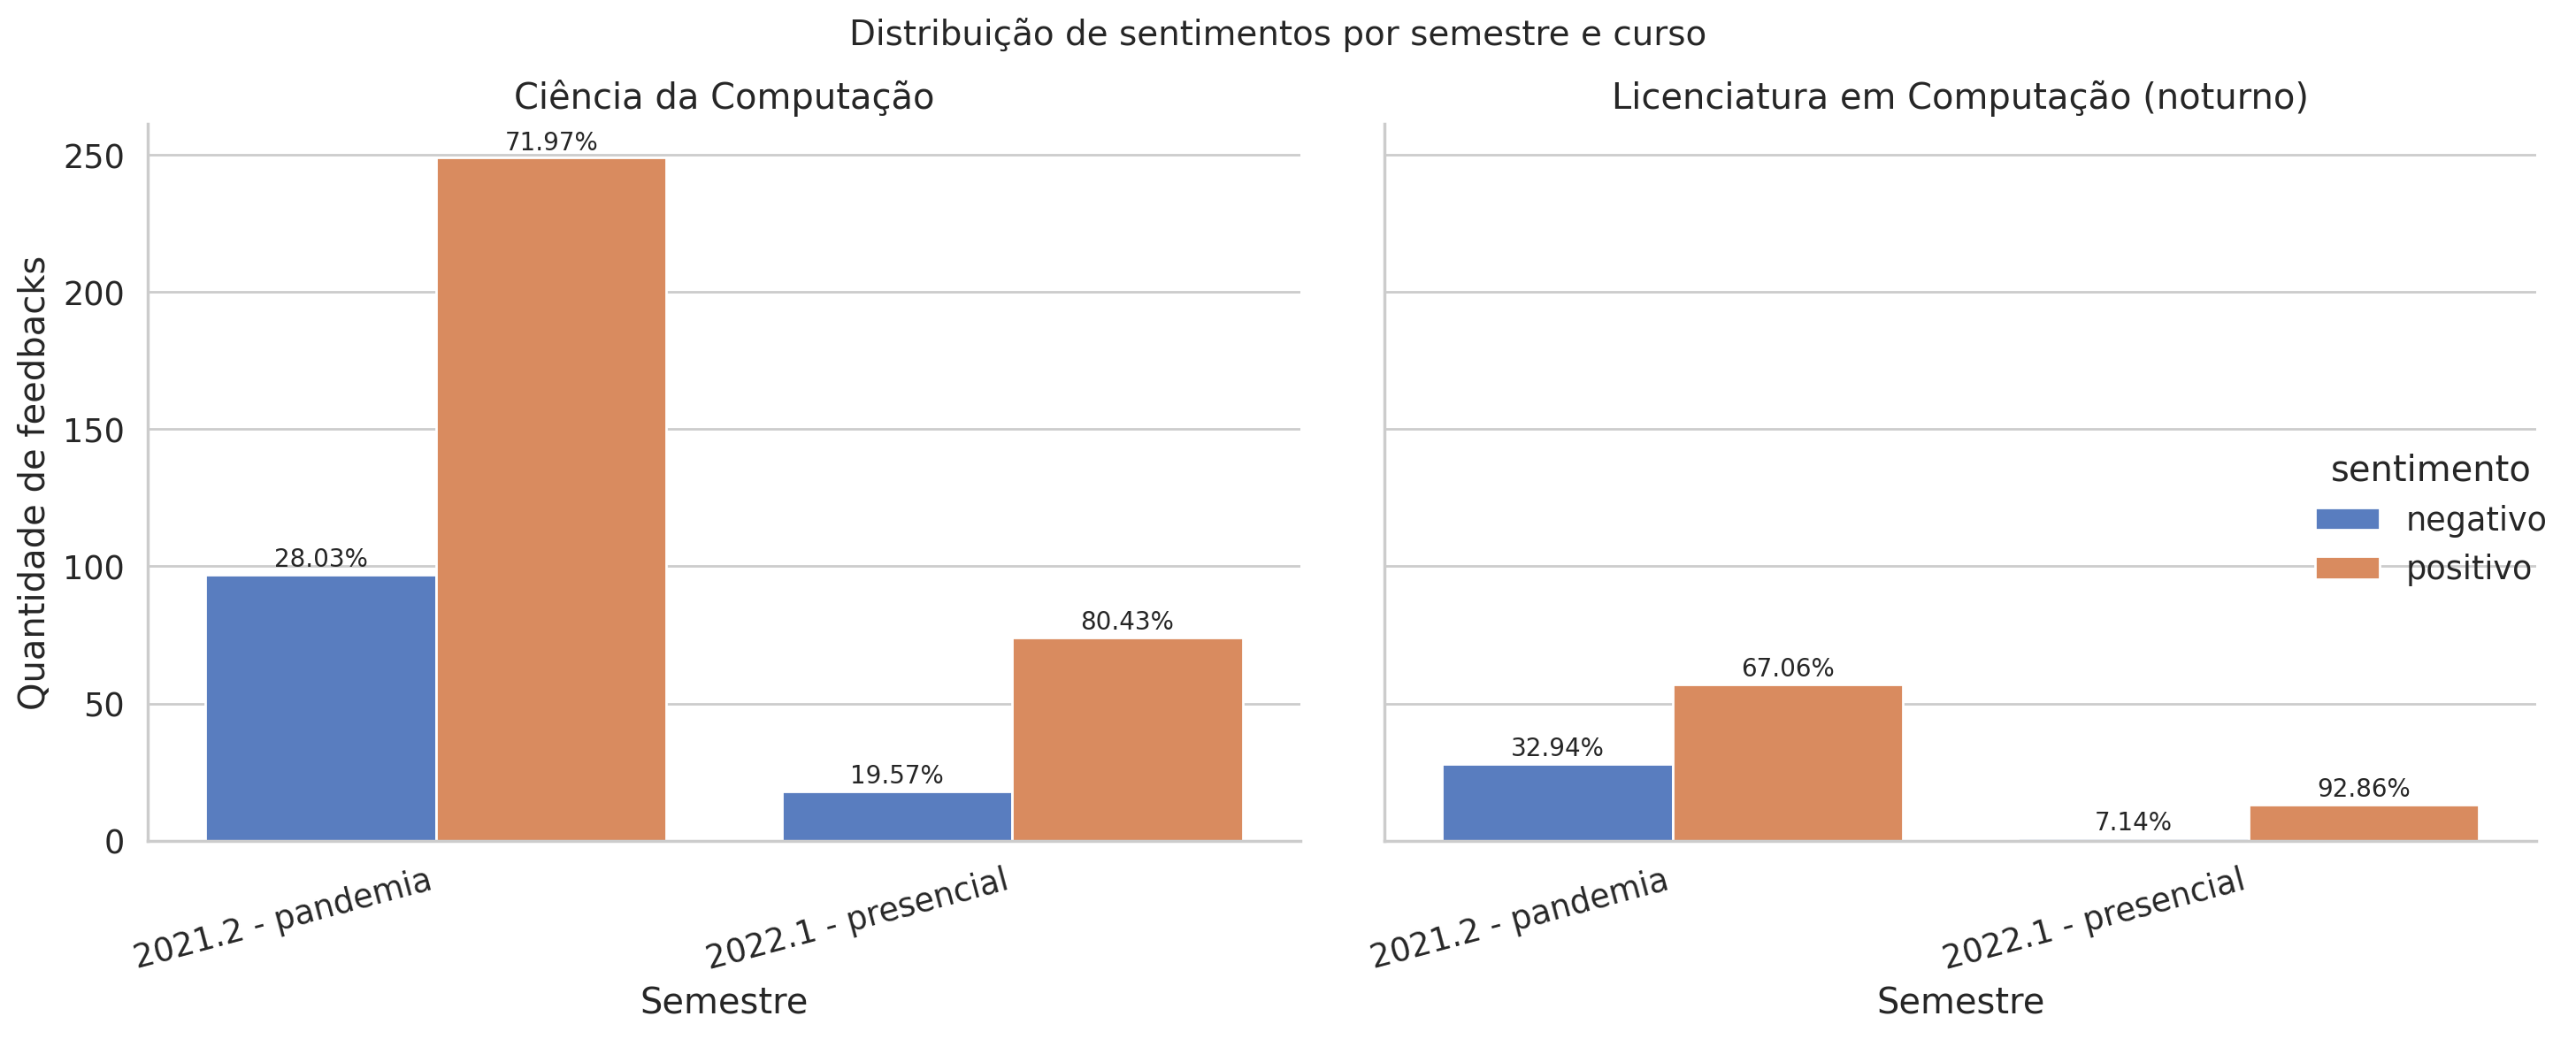

In [ ]:
# Garante ordenação consistente
dados_analise4 = dados_analise4.sort_values("sentimento").reset_index(drop=True)

# Gráfico de barras separado por curso
g = sns.catplot(
    data=dados_analise4,
    x="semestre", y="quantidade", hue="sentimento",
    col="curso",
    kind="bar",
    height=6, aspect=1.1
)

# Adiciona porcentagens nas barras
for ax, (curso, grupo_curso) in zip(g.axes.flat, dados_analise4.groupby("curso")):
    grupo_curso = grupo_curso.reset_index(drop=True)

    for patch, (_, row) in zip(ax.patches, grupo_curso.iterrows()):
        altura = patch.get_height()
        x = patch.get_x() + patch.get_width() / 2
        porcentagem = row["porcentagem"]

        ax.text(x, altura + 1, f'{porcentagem:.2f}%', ha='center', va='bottom', fontsize=10)

# Ajustes visuais
g.set_titles("{col_name}")
g.set_axis_labels("Semestre", "Quantidade de feedbacks")
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right')

g.fig.suptitle("Distribuição de sentimentos por semestre e curso", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

In [ ]:
!pip freeze > requirements.txt